### Firstly, we are going to texture a 3D mesh using mayavi lib

In [29]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

In [30]:
im1 = Image.open("esophagus.jpg")

In [31]:
im2 = im1.rotate(90)
im2.save("tmp/texture6.jpg")

In [32]:
bmp1 = tvtk.JPEGReader(file_name="tmp/texture6.jpg")

In [33]:
my_texture=tvtk.Texture()
my_texture.interpolate=0

In [34]:
# my_texture.set_input(0,bmp1.get_output())
#tvtk.configure_input(my_texture, bmp1)
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [35]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/ASR.ply"))

In [36]:
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture
#mlab.show()
mlab.show()

### we are going to smaple images' pixels from images

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [38]:
img=mpimg.imread('esophagus.jpg')

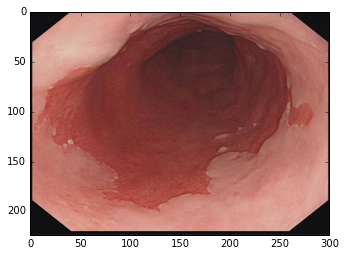

In [39]:
plt.imshow(img)
plt.show()

In [40]:
img.shape

(224L, 300L, 3L)

In [41]:
import random
import cv2
sample_array=[]
r=50
center=[img.shape[0]/2,150]
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (i-center[0])**2+(j-center[1])**2<=100**2:
            sample_array.append(list(img[i,j,:]))
            
#array=np.array(sample_array)
length=len(sample_array)

constructed_image=[]
for i in range(img.shape[0]):
    temp_array=[]
    for j in range(img.shape[1]):
        randnum=random.randint(0,length-1)
        temp_array.append(sample_array[randnum])
    constructed_image.append(temp_array)
constructed_image=np.array(constructed_image)

In [42]:
blur = cv2.GaussianBlur(constructed_image,(7,7),0)
dst = cv2.fastNlMeansDenoisingColored(blur,None,10,10,7,21)

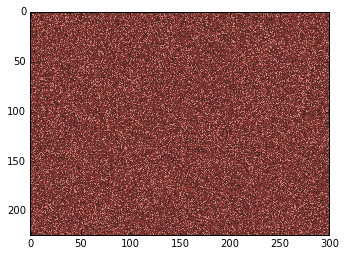

In [43]:
plt.imshow(constructed_image)
plt.show()

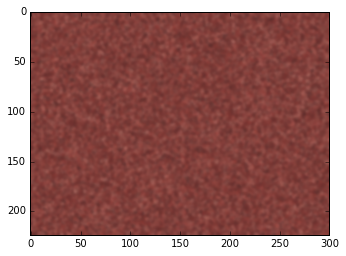

In [44]:
plt.imshow(blur)
plt.show()

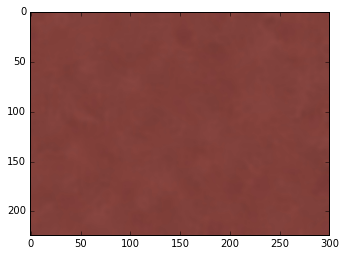

In [45]:
plt.imshow(dst)
plt.show()

In [46]:
import scipy.misc
scipy.misc.imsave('sampled_texture.jpg', blur)

### Now,we are going to use sampled image to texture 3D-mesh 

In [47]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

im1 = Image.open("sampled_texture.jpg")
im2 = im1.rotate(90)
im2.save("tmp/sampled_texture.jpg")
bmp1 = tvtk.JPEGReader(file_name="tmp/sampled_texture.jpg")

my_texture=tvtk.Texture()
my_texture.interpolate=0
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [48]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/target.ply"))
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture

In [49]:
image_files=[]
for i in range(100):
    image_files.append("test_images/view"+str(i)+".png")
poses=[]
focs=[]
# view = mlab.view()
# roll = mlab.roll()

cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[0]) 

view = mlab.view()
roll = mlab.roll()

mlab.move(45,0,0)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[1])

mlab.view(*view)
mlab.roll(roll)

mlab.move(0,45,0)
mlab.yaw(16)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[2])

mlab.view(*view)
mlab.roll(roll)

mlab.move(0,-45,0)
mlab.yaw(-16)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[3])

mlab.view(*view)
mlab.roll(roll)

mlab.move(-45,0,0)
mlab.yaw(12)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[4])

mlab.view(*view)
mlab.roll(roll)

mlab.move(45,45,0)
mlab.yaw(12)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[5])

mlab.view(*view)
mlab.roll(roll)

mlab.move(-45,-45,0)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[6])

mlab.view(*view)
mlab.roll(roll)

mlab.move(-45,-45,0)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[7])

mlab.view(*view)
mlab.roll(roll)

mlab.move(0,0,45)
mlab.pitch(-12)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[8])

mlab.view(*view)
mlab.roll(roll)

mlab.move(0,0,-45)
mlab.pitch(12)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[9])

mlab.view(*view)
mlab.roll(roll)

mlab.move(0,0,45)
mlab.move(45,0,0)
mlab.pitch(-12)
mlab.move(45,0,0)
mlab.move(0,0,20)
mlab.pitch(-12)
mlab.move(45,0,0)
mlab.pitch(-20)
mlab.move(0,0,20)
mlab.move(70,0,0)
mlab.pitch(-50)
# mlab.move(30,0,70)

cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[10])

mlab.view(*view)
mlab.roll(roll)

mlab.move(45,45,0)
mlab.yaw(15)
mlab.move(45,20,0)
mlab.yaw(20)
mlab.move(30,30,0)
mlab.yaw(20)
mlab.move(30,30,0)
mlab.yaw(35)
mlab.move(5,25,0)
mlab.yaw(30)
mlab.move(-30,0,0)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[11])

mlab.view(*view)
mlab.roll(roll)

mlab.move(150,0,0)
cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
mlab.savefig(image_files[12])

mlab.view(*view)
mlab.roll(roll)

0.0

In [50]:
len(poses)

13

In [51]:
import json
poses=np.array(poses)

dict_test={}
dict_test_poses={}
for i in range(len(poses)):
    dict_test_poses["view"+str(i)+"_camera_pose"]=list(poses[i])
dict_test['camera_poses']=dict_test_poses

dict_test_focal_point={}
for i in range(len(poses)):
    dict_test_focal_point["view"+str(i)+"_focal_point"]=list(focs[i])
dict_test['focal_points']=dict_test_focal_point

with open('test_images/camera_pose.json', 'w') as fp:
    json.dump(dict_test, fp)

In [ ]:
#dict_test['focal_points']
#mlab.show()
mlab.show()

### Try to use a general way to generate different ways

In [29]:
image_file_names=[]
for i in range(100):
    image_file_names.append("saved_images/screenshot"+str(i)+".png")

camera_poses=[]
camera_focs=[]
for i in range(100):
    cam,foc = mlab.move()
    camera_poses.append(cam)
    camera_focs.append(foc)
    mlab.savefig(image_file_names[i])
#     x=random.uniform(-1,1)
#     y=random.uniform(-1,1)
#     z=random.uniform(-1,1)
#     mlab.move(x,y,z)
    degree1=random.uniform(-90,90)
    degree2=random.uniform(-90,90)
    roll = mlab.roll()
    f = mlab.gcf()
    camera = f.scene.camera
    camera.yaw(degree1)
#     mlab.pitch(degree1)
#     mlab.yaw(degree2)

In [22]:
import json
camera_poses=np.array(camera_poses)
dic_poses={}
for i in range(100):
    dic_poses["screen shot "+str(i)+" pose"]=list(camera_poses[i])
dic_poses
with open('camera_pose_json/camera_pose.json', 'w') as fp:
    json.dump(dic_poses, fp)

In [46]:
#mlab.show()
mlab.show()

### Then, we also can use opencv to calculate camera's translation and rotation

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img1 = cv2.imread('3D-mesh-image-screen-shot/shot1.png',0)  #queryimage # left image
img2 = cv2.imread('3D-mesh-image-screen-shot/shot3.png',0) #trainimage # right image
sift = cv2.SIFT()
#sift = cv2.xfeatures2d.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
#matches = flann.knnMatch(None,None,k=2)
good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [56]:
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

In [57]:
F

array([[  3.00509119e-05,   3.69686461e-05,  -1.17710095e-02],
       [ -2.66883598e-05,  -1.25196832e-05,   7.92030192e-03],
       [ -1.15878857e-03,  -5.80374852e-03,   1.00000000e+00]])

In [25]:
# Author: S. Chris Colbert <sccolbert@gmail.com>
# Copyright (c) 2009, S. Chris Colbert
# License: BSD Style

from __future__ import print_function

# this import is here because we need to ensure that matplotlib uses the
# wx backend and having regular code outside the main block is PyTaboo.
# It needs to be imported first, so that matplotlib can impose the
# version of Wx it requires.
import matplotlib
matplotlib.use('WXAgg')
import pylab as pl


import numpy as np
from mayavi import mlab
from mayavi.core.ui.mayavi_scene import MayaviScene

C:\Users\lixx3527\Anaconda2\envs\dato-env\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [26]:
def get_world_to_view_matrix(mlab_scene):
    """returns the 4x4 matrix that is a concatenation of the modelview transform and
    perspective transform. Takes as input an mlab scene object."""

    if not isinstance(mlab_scene, MayaviScene):
        raise TypeError('argument must be an instance of MayaviScene')


    # The VTK method needs the aspect ratio and near and far clipping planes
    # in order to return the proper transform. So we query the current scene
    # object to get the parameters we need.
    scene_size = tuple(mlab_scene.get_size())
    clip_range = mlab_scene.camera.clipping_range
    aspect_ratio = float(scene_size[0])/float(scene_size[1])

    # this actually just gets a vtk matrix object, we can't really do anything with it yet
    vtk_comb_trans_mat = mlab_scene.camera.get_composite_projection_transform_matrix(
                                aspect_ratio, clip_range[0], clip_range[1])

     # get the vtk mat as a numpy array
    np_comb_trans_mat = vtk_comb_trans_mat.to_array()

    return np_comb_trans_mat

In [27]:
def get_view_to_display_matrix(mlab_scene):
    """ this function returns a 4x4 matrix that will convert normalized
        view coordinates to display coordinates. It's assumed that the view should
        take up the entire window and that the origin of the window is in the
        upper left corner"""

    if not (isinstance(mlab_scene, MayaviScene)):
        raise TypeError('argument must be an instance of MayaviScene')

    # this gets the client size of the window
    x, y = tuple(mlab_scene.get_size())

    # normalized view coordinates have the origin in the middle of the space
    # so we need to scale by width and height of the display window and shift
    # by half width and half height. The matrix accomplishes that.
    view_to_disp_mat = np.array([[x/2.0,      0.,   0.,   x/2.0],
                                 [   0.,  -y/2.0,   0.,   y/2.0],
                                 [   0.,      0.,   1.,      0.],
                                 [   0.,      0.,   0.,      1.]])

    return view_to_disp_mat


def apply_transform_to_points(points, trans_mat):
    """a function that applies a 4x4 transformation matrix to an of
        homogeneous points. The array of points should have shape Nx4"""

    if not trans_mat.shape == (4, 4):
        raise ValueError('transform matrix must be 4x4')

    if not points.shape[1] == 4:
        raise ValueError('point array must have shape Nx4')

    return np.dot(trans_mat, points.T).T

C:\Users\lixx3527\Anaconda2\envs\dato-env\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: This function is deprecated. Please call randint(-3, 3 + 1) instead
C:\Users\lixx3527\Anaconda2\envs\dato-env\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: This function is deprecated. Please call randint(-3, 3 + 1) instead
C:\Users\lixx3527\Anaconda2\envs\dato-env\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: This function is deprecated. Please call randint(-3, 3 + 1) instead


Point 0:  (x, y)  [ 144.89122593  121.68293446]
Point 1:  (x, y)  [ 186.92415811  236.54274916]
Point 2:  (x, y)  [ 188.97824519  198.04389176]
Point 3:  (x, y)  [ 209.03477083  116.98640839]


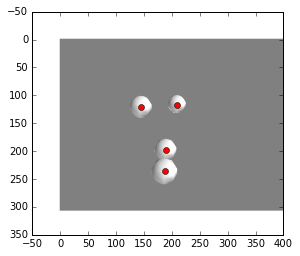

In [28]:
f = mlab.figure()

N = 4

# create a few points in 3-space
X = np.random.random_integers(-3, 3, N)
Y = np.random.random_integers(-3, 3, N)
Z = np.random.random_integers(-3, 3, N)

# plot the points with mlab
pts = mlab.points3d(X, Y, Z)

# now were going to create a single N x 4 array of our points
# adding a fourth column of ones expresses the world points in
# homogenous coordinates
W = np.ones(X.shape)
hmgns_world_coords = np.column_stack((X, Y, Z, W))

# applying the first transform will give us 'unnormalized' view
# coordinates we also have to get the transform matrix for the
# current scene view
comb_trans_mat = get_world_to_view_matrix(f.scene)
view_coords = \
        apply_transform_to_points(hmgns_world_coords, comb_trans_mat)

# to get normalized view coordinates, we divide through by the fourth
# element
norm_view_coords = view_coords / (view_coords[:, 3].reshape(-1, 1))

# the last step is to transform from normalized view coordinates to
# display coordinates.
view_to_disp_mat = get_view_to_display_matrix(f.scene)
disp_coords = apply_transform_to_points(norm_view_coords, view_to_disp_mat)

# at this point disp_coords is an Nx4 array of homogenous coordinates
# where X and Y are the pixel coordinates of the X and Y 3D world
# coordinates, so lets take a screenshot of mlab view and open it
# with matplotlib so we can check the accuracy
img = mlab.screenshot()
pl.imshow(img)

for i in range(N):
    print('Point %d:  (x, y) ' % i, disp_coords[:, 0:2][i])
    pl.plot([disp_coords[:, 0][i]], [disp_coords[:, 1][i]], 'ro')

pl.show()

# you should check that the printed coordinates correspond to the
# proper points on the screen

mlab.show()

#EOF